# Automatic CT segmentation using Nvidia Vista-3D and vessels geometry analysis and visualization with Streamlit on PCAI


## 🧩 Problem statement

 Obtain **geometrical biomarkers** (e.g. cross-sectional diameters and tortuosity index) from CT exams available in Dicom format.

---

## 🎯 Target outcome

- **Automatically segment** aorta, right and left common iliac arteries available in Dicom format
- Availability of a **custom Jupyter Notebook (PC-AI compatible)** preloaded with Nvidia Vista 3D model and essential tools for postprocessing
- Postprocessing of the segmentation output, preparing it for **geometrical analysis and 3D visualization**
- Availability of a PC-AI compatible app with **Streamlite**. Within the app, it must be possible to execute geometrical analysis, visualize segmentation output and 3D renderings 

---

##  📊 High-Level Demo Flow

![workflow](../../docs/images/conceptual_workflow_white.png)

    1. Load Dicom files and convert to Nifti format for semantic segmentation
    2. Segment data using Vista-3D model
    3. Postprocess the output to extract classes of interest (aorta, common iliac arteries)
    4. Postprocess the segmentation output, preparing it for analysis with the created Streamlit app
    5. Identify vessels' centerline
    6. Measure vessels' diameter along the centerline, identifying cross-sections planes
    7. Measure vessels' tortousity index
    8. Prepare 3D renderings of the vessels and visualize them


**Note:** this notebook walks you through the steps 1-4. 

Steps 5-8 can be conducted directly using the `vessels geometry analysis and reconstruction app`, for which, instructions are provided at the bottom of this notebook.

## 🛠️ Step-by-Step Instructions


###  🔧 Environment Preparation

Install Python dependecies

In [1]:
%pip install pydicom dicom2nifti nibabel plotly open3d python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Load all the libraries
from pathlib import Path
import os
import dicom2nifti
import warnings
import requests
import zipfile
from dotenv import load_dotenv
import nibabel as nib
import numpy as np
import json 

## Set-up API key and specify the URL of Vista-3D model, to be used for segmentation.

### - Deploy Vista-3D model to MLIS. 
 
 Here is a  [how to deploy NIM to MLIS](./docs/deploy-NIM-to-MLIS.pdf) guide.


### ⚠️ Model requirements:

The model requires a path to the MLIS' endpoint and a USER TOKEN KEY, which need to be stored in a .env file locate in the same folder where this notebook resides:

E.g. of the content in the .env file

---

```.env
MLIS_TOKEN="$YOUR_MLIS_TOKEN$"
BASE_URL="$YOUR_PCAI_MODEL_BASE_URL$"
``` 

----

Where:

- MLIS_TOKEN is the authentication token 
- BASE_URL is the path to the model endpoint in MLIS.


In [3]:
# Load secret keys from .env file
load_dotenv()
# Specify the model endopoint within MLIs
base_url = os.getenv('BASE_URL')
if base_url is not None:
    print(f"Using model at: {base_url}")
else:
    raise ValueError("BASE_URL was not specified, check your .env file")

# Specity the MLIs authorization token
mlis_token = os.getenv('MLIS_TOKEN')
if mlis_token is not None:
    print(f"MLIS token loaded successfully!")
else:
    raise ValueError("MLIS_TOKEN was not specified, check your .env file")

Using model at: https://vista-predictor-andrew-mendez-4a1f9d06.ingress.pcai0109.dc15.hpecolo.net
MLIS token loaded successfully!


### Prepare your data
**In this example - Dicom data are organized as follows:**
 
> dicom_data/
>>       PATIENT01/
>>>           dicom_file_CT......1
>>>           dicom_file_CT......2
>>>           dicom_file_CT......3
>>>           ...
>>       PATIENT02/
>>>           dicom_file_CT......1
>>>           dicom_file_CT......2
>>>           dicom_file_CT......3
>>>           ....
 
Ensure to specify the parent folder i.e. `dicom_data`,  when you specify the location of the data in `DICOM_DATA_PATH` below.

⚠️ **NOTE:** If the dataset is available in **Nifti** format instead of **Dicom**, you won't need to create the Nifti files which are required by the Nvidia Vista-3D segmentation model.

In that case you can prepare the dataset as in the following example, in which we will use the `Fast and Low-resource semisupervised Abdominal oRgan  sEgmentation (FLARE) Challenge` dataset.

FLARE is a dataset for abdomen organ segmentation and it has many important clinical applications, such as organ quantification, surgical planning, and disease diagnosis. Although it is not designed for vessels segmentation, it contains in some scans Aorta, Right and Left Iliac Arteries, so we can use it to demo our app.

- Challenge link: [FLARE22](https://flare22.grand-challenge.org)

- Dataset repository: [FLARE22 dataset](https://storage.googleapis.com/ai-solution-engineering-datasets/demo-test-seg.zip)


**Download** the dataset and save it so that it is organized as follows:

> outputs
>> nifti_data
>>> training
>>>> FLARETs_0001_0000.nii.gz

>>> tuning
>>>> FLARETs_0002_0000.nii.gz

>>> testing
>>>> FLARETs_0050_0000.nii.gz

### Specify important paths

In [ ]:
## These are the only paths that need to be modified!

# If dataset is in Dicom format - Specify the folder where Dicom data reside:
DICOM_DATA_PATH = Path('dicom_data') 

# Specify the folder where all the outputs will be saved
ALL_OUTPUTS_PATH = Path('outputs_flare')

# Specify the URL where data reside so that Vista3D model can fetch it:
# Please refer to https://docs.nvidia.com/nim/medical/vista3d/latest/advanced-usage.html#environment-variables for additional details.
# Hint: if data are in 'https://fs2.ingress.pcai0109.dc15.hpecolo.net/califra/dicom_data'
# data_path_root must be 'https://fs2.ingress.pcai0109.dc15.hpecolo.net/califra/'
data_path_root = 'Please specify the URL here'

# Set the following to True if you want to convert the data Dicom to Nifti
CONVERT_DICOM_TO_NIFTI = False

In [ ]:
# Assess whether the FLARE dataset has been organized correctly
if not CONVERT_DICOM_TO_NIFTI:
    ## Check data were correctly organized
    assert (
        ALL_OUTPUTS_PATH / "nifti_data" / "testing" / "FLARETs_0050_0000.nii.gz"
        ).is_file(), (
            "Ensure the FLARE dataset is organized as expected. Look instructions above - Ignore this message otherwise"
            )

## 🔧 1) Load Dicom files and convert to Nifti format for semantic segmentation

**⚠️ NOTE:** you can skip this step if the data is already available in Nifti format.

In this section, we show how to convert Dicom file to Nifti (Neuroimaging Informatics Technology Initiative) format which is the format expected by the Vista-3D Nvidia NIM model (more details about the model are provided below).


Upon completion data will be organized in the specified folder with a structure similar to what we saw for dicom_data. 

Eg:
> dicom_data
>>   PATIENT01
>>>        dicom_file_CT......1
>>>        dicom_file_CT......2

> nifti_data
>>   PATIENT01
>>>        3_25mm_arterial.nii.gz
>>>        601_coronal_abdomen.nii.gz
>>>        602_sagittal_abdomen.nii

Note that the name is self-inferred using the Dicom metadata tag.

In this example:
>    (0008,103E) Series Description  LO: '2.5MM ARTERIAL'

In [ ]:
# If you converted your data from Dicom to Nifti using the code above, then your Nifti data will be in nifti_data folder. 
nifti_destination_path = Path(ALL_OUTPUTS_PATH) / "nifti_data"

if CONVERT_DICOM_TO_NIFTI:
    # Convert Dicom to Nifti for compatibility with the Vista-3D Nvidia NIM model
    for dicom_directory in os.listdir(DICOM_DATA_PATH):
        input_directory = Path(DICOM_DATA_PATH) / f"{dicom_directory}" 
        output_directory = Path(nifti_destination_path) / dicom_directory
    
        # If the patient's exam has already been processed, skip it.
        if output_directory.exists():
            warnings.warn(f"{output_directory} already exists, skipping...")
            continue
        else:
            os.makedirs(output_directory, exist_ok=False)
            print("-"*10)
            print(f"Saving Nifti files into directory {output_directory}")
            dicom2nifti.convert_directory(input_directory, output_directory, compression=True, reorient=True)

## 🧠 2) Segment data using Vista-3D model (133 classes)

In this project we chose the **Vista-3D Nvidia NIM** model for segmenting the tissues of interest. 

##### 📦 Vista-3D Foundation Model
Vista-3D Nvidia model is state of the art in zero-shot segmentation of CT scans, and **HPE Private-Cloud AI** comes with Nvidia licenses, making it a great option.

[Vista-3D is a specialized interactive foundation model for 3D medical imaging.](https://build.nvidia.com/nvidia/vista-3d/modelcard) It excels in providing accurate and adaptable segmentation analysis across 133 anatomies and modalities. Utilizing a multi-head architecture, Vista-3D adapts to varying conditions and anatomical areas, helping guide users' annotation workflow. This model is for research purposes and not for clinical usage.

##### 📁 Training Data Details
The Vista3D model was trained by Nvidia on a large and diverse dataset of 11454 3D CT volumes. This dataset was curated from Nvidia in-house and publicly available sources. The training data encompassed a wide range of acquisition protocols.

##### 📄 Reference 
- [Vista3D: A Unified Segmentation Foundation Model For 3D Medical Imaging
](https://arxiv.org/pdf/2406.05285)
- [Segment Anything](https://arxiv.org/abs/2304.02643)

#### ⚡ HPE Machine Learning Inference Software
In this notebook, the Vista-3D model has been deployed using **[HPE's Machine Learning Inference Software (MLIS)](https://docs.ai-solutions.ext.hpe.com/products/mlis/)**, which simplifies and controls the deployment, management, and monitoring of machine learning models at scale. Here is a [HOW-TO](./docs/deploy-NIM-to-MLIS.pdf) guide on deploying models to MLIs. 

In [ ]:
# To perform segmentation using Vista 3D model, we need to send a post request to the MLIs endpoint. 
# As part of the request we need to specify the path to the Nifti file to be segmented out.

# Update the nvidia token
%update_token

def unzip_file(zip_filepath, output_dir, output_filename=None):
    """Unzip the first file in a zip archive to a target folder, optionally renaming it."""
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        info_list = zip_ref.infolist()
        if not info_list:
            raise ValueError("Zip file is empty")

        first_entry = info_list[0]
        original_name = first_entry.filename

        # Ensure output directory exists
        os.makedirs(output_dir, exist_ok=True)

        # Extract the file to the output directory
        extracted_path = zip_ref.extract(original_name, path=output_dir)

        # Optionally rename the extracted file
        if output_filename:
            new_path = os.path.join(output_dir, output_filename)
            os.rename(extracted_path, new_path)
            return new_path
        return extracted_path


# Location where the model responses and segmentation outputs will land
response_dir = Path(ALL_OUTPUTS_PATH) / "responses"
os.makedirs(response_dir, exist_ok=True)

segmentation_dir = Path(ALL_OUTPUTS_PATH) / "segmentations"
os.makedirs(segmentation_dir, exist_ok=True)

# Specify the location of the data, they need to be available and accessible online for the model to be able to process them.
# Here we use the location within the hosted-trial environment

headers = {'Authorization': f'Bearer {mlis_token}'}

# Vista-3D model requires passing the data in a dictionary, which has a key `image` that points to a URL to the Nifti file. 
# e.g. data['image'] = "https://fs2.ingress.pcai0109.dc15.hpecolo.net/califra/outputs/nifti_data/testing/FLARETs_0050_0000.nii.gz"
# Please refer to https://docs.nvidia.com/nim/medical/vista3d/latest/advanced-usage.html#environment-variables for additional details.
# Note that Vista-3D model will attempt segmenting every Nifti file irrespective of the acquisition orientation (axial, coronal, sagittal).
# Zero-shot segmentation quality should be state of the art on all the planes.

for path in Path(nifti_destination_path).rglob('*nii.gz'):
    data = {}
    # User TODO: 
    # Ensure 'path' does not require custom logic. 
    # This is may be needed if ALL_OUTPUTS_PATH is not a relative path.

    p = data_path_root +  str(path)
    data['image'] = str(p)
    print("-" * 10)

    # Submit a post request to segment the ct scan.
    response = requests.post(f'{base_url}/v1/vista3d/inference', json=data, headers=headers)
    
    if response.status_code == 200: # Success!!

        file_name = path.name
        
        # Create the folders required to have a clean output
        os.makedirs(Path(response_dir) / path.parent.name, exist_ok=True)
        os.makedirs(Path(segmentation_dir) / path.parent.name, exist_ok=True)

        output_segmentation_name = Path(segmentation_dir) / path.parent.name / file_name

        # Zip the model response, unzip it and rename the files accordingly
        output_zip_name = Path(response_dir) / path.parent.name / file_name.replace('.nii.gz', '.zip') 
        
        with open(output_zip_name, 'wb') as f:
            f.write(response.content)
    
        _ = unzip_file(
            zip_filepath=str(output_zip_name),
            output_dir = "/".join(str(output_segmentation_name).split("/")[:-1]),
            output_filename=str(output_segmentation_name).split("/")[-1],
        )
        print(f'{str(path)} {response}')

    else:
        print("skipping: ", data['image'], '\n', response.status_code)
    

Token successfully refreshed.
----------
outputs_flare/nifti_data/testing/FLARETs_0026_0000.nii.gz <Response [200]>
----------
outputs_flare/nifti_data/testing/FLARETs_0050_0000.nii.gz <Response [200]>
----------
outputs_flare/nifti_data/testing/FLARETs_0147_0000.nii.gz <Response [200]>
----------
outputs_flare/nifti_data/testing/FLARETs_0148_0000.nii.gz <Response [200]>
----------
outputs_flare/nifti_data/testing/FLARETs_0186_0000.nii.gz <Response [200]>
----------
outputs_flare/nifti_data/testing/FLARETs_0194_0000.nii.gz <Response [200]>


## 🖼️ Segmentation output

Upon segmentation, the results will be available in folder `outputs/segmentations` with exactly the same structure as saw for the Nifti data.

E.g.:

> outputs
>>nifti_data
>>>   testing
>>>>        FLARETs_0050_0000.nii.gz

>> segmentations
>>>   testing
>>>>        FLARETs_0050_0000.nii.gz

## 🧪 3) Postprocess the output to extract classes of interest (aorta, common iliac arteries)

- a) Load the segmentation label mapping for each anatomical structure. Remember that Vista 3D model can segment up 133 (including background) tissues.
- b) Post-process the segmentation output to extract only the 3 tissues we are interested on (aorta, left iliac artery, right iliac artery)

In [28]:
with open('vista3dmodelinfo.json', 'rb') as f:
    segmentation_dict  = json.load(f)['labels']

segmentation_dict = {v: k for k, v in segmentation_dict.items()}

print("Mapping tissue to label:")
for tissue, label in segmentation_dict.items():
    print(f"{tissue}: {label}")

Mapping tissue to label:
background: 0
liver: 1
kidney: 2
spleen: 3
pancreas: 4
right kidney: 5
aorta: 6
inferior vena cava: 7
right adrenal gland: 8
left adrenal gland: 9
gallbladder: 10
esophagus: 11
stomach: 12
duodenum: 13
left kidney: 14
bladder: 15
prostate or uterus: 16
portal vein and splenic vein: 17
rectum: 18
small bowel: 19
lung: 20
bone: 21
brain: 22
lung tumor: 23
pancreatic tumor: 24
hepatic vessel: 25
hepatic tumor: 26
colon cancer primaries: 27
left lung upper lobe: 28
left lung lower lobe: 29
right lung upper lobe: 30
right lung middle lobe: 31
right lung lower lobe: 32
vertebrae L5: 33
vertebrae L4: 34
vertebrae L3: 35
vertebrae L2: 36
vertebrae L1: 37
vertebrae T12: 38
vertebrae T11: 39
vertebrae T10: 40
vertebrae T9: 41
vertebrae T8: 42
vertebrae T7: 43
vertebrae T6: 44
vertebrae T5: 45
vertebrae T4: 46
vertebrae T3: 47
vertebrae T2: 48
vertebrae T1: 49
vertebrae C7: 50
vertebrae C6: 51
vertebrae C5: 52
vertebrae C4: 53
vertebrae C3: 54
vertebrae C2: 55
vertebrae C

📏 Measure diameters of vessels.

We take the measurements in the axial plane scans - to do se, we identify the cross-section planes of the vessels. This is done within the `vessel geometry analysis and reconstruction` app, which we introduce below.

For this reason, we create a dictionary that for each patient contains only the paths to the Nifti files that contain axial planes.

In [32]:
patient_dict = {}
for patient_paths in (Path(ALL_OUTPUTS_PATH) / 'nifti_data').rglob('*nii.gz'):
    patient = patient_paths.parent.name
    if patient not in patient_dict:
        patient_dict[patient] = []

    
    if "sa" not in str(patient_paths.resolve()) and "co" not in str(patient_paths.resolve()):
        patient_dict[patient].append(str(patient_paths.resolve()))

patient_dict

{'testing': ['/mnt/shared/califra/outputs_flare/nifti_data/testing/FLARETs_0026_0000.nii.gz',
  '/mnt/shared/califra/outputs_flare/nifti_data/testing/FLARETs_0050_0000.nii.gz',
  '/mnt/shared/califra/outputs_flare/nifti_data/testing/FLARETs_0147_0000.nii.gz',
  '/mnt/shared/califra/outputs_flare/nifti_data/testing/FLARETs_0148_0000.nii.gz',
  '/mnt/shared/califra/outputs_flare/nifti_data/testing/FLARETs_0186_0000.nii.gz',
  '/mnt/shared/califra/outputs_flare/nifti_data/testing/FLARETs_0194_0000.nii.gz']}

## 🛠️ 4) Prepare data for further analysis

Here we process the segmentation output and prepare it for processing using the `vessels geometry analysis and reconstruction app`.

The steps below include:

- limiting the segmentation outputs to include only the vessels of interest (aorta, right and left common iliac arteries)
- projecting the segmented voxels from voxel to the real world space, identifying (x, y, z) coordinates of each voxel

In [33]:
# Extract the mapping between segmentation label and segmentation numerical value, using the segmentation dict provided by the Vista-3D model which we previously loaded in memory (i.e. 'vista3dmodelinfo.json')

# In this study we are interested on 3 vessels, but could be expanded to any additional vessel/ tissue, provided the segmentation is available. Please refer to the 'vista3dmodelinfo.json' file, or the official Vista-3D model documentation.
label_rois = ['aorta', 'left iliac artery', 'right iliac artery']
vessel_labels = {k: int(segmentation_dict[k]) for k in label_rois}

for idx, patient_id in enumerate(patient_dict.keys()):

    patient = patient_id

    print("-" * 10)
    print(">> processing patient: ", patient)

    for series, scan_path in enumerate(patient_dict[patient]):
        try:
            scan_path_lower = scan_path.lower()
            volume_name = Path(patient_dict[patient][series]).name.replace(".nii.gz", "")
            print(f"processing {volume_name} for patient {patient}")
            
            # Load the CT to memory
            ct_data = nib.load(scan_path)
            ct_scan = ct_data.get_fdata()
            affine = ct_data.affine
          
            # Load the segmentation to memory
            segmentation_path = patient_dict[patient][series].replace('nifti_data', 'segmentations')
            segmentation_data = nib.load(segmentation_path)
            segmentation_scan = segmentation_data.get_fdata()
            
            # Create a new segmentation map with only the vessels of interest in it.
            new_segmentation_scan = np.zeros_like(segmentation_scan)
            for n,label in enumerate(vessel_labels.values(), start=1):
                new_segmentation_scan += (segmentation_scan == label)*n
            
            # Create a new dict with the vessel labels
            new_vessel_labels = {
                k_key: id_k for id_k, (k_key, k_value) in enumerate(vessel_labels.items(), start=1)
            }
    
            print("After processing segmentation, the new labels mapping is:\n")
            for tissue, label in new_vessel_labels.items():
                print(f"{tissue}: {label}")
       
            # ----------------------------------------------------------------------------
            # Build the 3D coordinate grid (patient coordinates in mm)
            
            # Build coordinate grid
            scan_size = ct_scan.shape #(4,4)
        
            # Meshgrid 3 integer volumes holding voxel indices (i,j,k)	(512, 512, 146) each
            grid_i, grid_j, grid_k = np.meshgrid(
                np.arange(scan_size[0]), np.arange(scan_size[1]), np.arange(scan_size[2]), indexing='ij'
            )
    
            # Since affine has shape 4x4, we need to stack a new column of 1s to make it the grid homogenous
            indices = np.stack([grid_i, grid_j, grid_k, np.ones_like(grid_i)], axis=-1)
        
            # Create a tensor, where each voxel's value is the coordinate of that voxel in the x, y, z coordinate space    
            # This uses the affine matrix provided by the Nifti files.
            coords = indices @ affine.T
    
            # Undo the homogenous shape by slicing away the row that we had for math convenience
            coords_xyz = coords[...,:3]
        
            
            # ----------------------------------------------------------------------------
            # Now that the coordinates are available in the x, y, z coordinate we can further process the results by
            # extracting only the points that belong to vessels' region of interest.
            
            mask = new_segmentation_scan > 0 # convert to binary
            points = coords_xyz[mask]   # shape (N,3)
            
            # Build colors based on segmentation label
            colors = np.zeros((points.shape[0], 3))
            
            flat_labels = new_segmentation_scan[mask]
            colors[flat_labels == 1] = [1, 0, 0]  # red for aorta
            colors[flat_labels == 2] = [0, 1, 0]  # green for left iliac
            colors[flat_labels == 3] = [0, 0, 1]  # blue for right iliac
            
            # Save pointclouds:
    
            pointcloud_dir = Path(ALL_OUTPUTS_PATH) / "pointclouds"
            os.makedirs(pointcloud_dir, exist_ok=True)
    
            patient_pointcloud_npz = Path(pointcloud_dir) / f"{patient_id}" / f"{volume_name}.npz"
    
            os.makedirs(patient_pointcloud_npz.parent, exist_ok=True)
            np.savez_compressed(patient_pointcloud_npz, points=points, colors=colors)
            print(f"Saved pointcloud with {points.shape[0]} points in \n{patient_pointcloud_npz}")
    
            # Save post processed segmentation:
            processed_segmentation_dir = Path(ALL_OUTPUTS_PATH) / "processed_segmentations" / patient_id
            vessel_segmentation_npz = Path(processed_segmentation_dir) / f"{volume_name}.npz"
    
            os.makedirs(processed_segmentation_dir, exist_ok=True)
            np.savez_compressed(vessel_segmentation_npz, new_seg_scan=new_segmentation_scan)
            print(f"{'-'*10}\nProcessed segmentation mask saved in \n{vessel_segmentation_npz}")
        except Exception as e:
            print(e)
            continue

----------
>> processing patient:  testing
processing FLARETs_0026_0000 for patient testing
After processing segmentation, the new labels mapping is:

aorta: 1
left iliac artery: 2
right iliac artery: 3
Saved pointcloud with 112561 points in 
outputs_flare/pointclouds/testing/FLARETs_0026_0000.npz
----------
Processed segmentation mask saved in 
outputs_flare/processed_segmentations/testing/FLARETs_0026_0000.npz
processing FLARETs_0050_0000 for patient testing
After processing segmentation, the new labels mapping is:

aorta: 1
left iliac artery: 2
right iliac artery: 3
Saved pointcloud with 46135 points in 
outputs_flare/pointclouds/testing/FLARETs_0050_0000.npz
----------
Processed segmentation mask saved in 
outputs_flare/processed_segmentations/testing/FLARETs_0050_0000.npz
processing FLARETs_0147_0000 for patient testing
After processing segmentation, the new labels mapping is:

aorta: 1
left iliac artery: 2
right iliac artery: 3
Saved pointcloud with 277661 points in 
outputs_flar

## 🔍 Visual inspection of the data 

Here we provide code snippets which are examplary of how to visualize the Nifti inputs and segmentation outputs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time


# --- Utility functions to visualize the segmentation overlayed to the acquisition scan ---
def visualize_slice(image, mask=None):
    """
    Visualize slice.

    Args:
        image: 2D np.array to visualize
        mask: Optional 2D np.array to overlay
    """
    plt.imshow(image, cmap=plt.cm.gray)
    if mask is not None:
        plt.imshow(np.ma.masked_where(mask==0, mask), cmap="jet", alpha=0.5, interpolation="none")


def visualize_scan(image, mask=None, interval=5, pause_time=0.1, show_slices=None, slice_dim="first"):
    """
    Visualize volume.

    Args:
        image: 3D np.array to visualize
        mask: Optional 3D np.array to overlay
        interval: int, interval between slices to be visualized 
        pause_time=0.1: float, pause between slice visualization
        show_slices=None: Optional[List[int]]. If None, shows all slices at the interval rate, else shows the specified slices
        slice_dim="first", whether slices are in the 'first' or 'last' dimension of the volume.

    """
    if slice_dim == "first":
        show_slices = show_slices or range(0, image.shape[0], interval)
    elif slice_dim == "last":
        show_slices = show_slices or range(0, image.shape[-1], interval)
    else:
        raise ValueError("slice axis must be first or last. Used ", slice_dim)

    for n in show_slices:
        if slice_dim == "first":
            visualize_slice(image[n]*1000, mask[n] if mask is not None else None )
        elif slice_dim == "last":
            visualize_slice(image[...,n]*1000, mask[...,n] if mask is not None else None)

        plt.title(f"Slice {n}")
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(pause_time)


In [35]:
# Print the name of patients available in the dataset
patients_ids = list(patient_dict.keys())
print(f"List of patients:")
for p_idx, p in enumerate(patients_ids):
    print(f"{p_idx} - {p}")

List of patients:
0 - testing


In [ ]:
# Select a patient among those printed above by specifying `idx` below, 
# and the code will print the name scan series available for inspection

# select one of the patients
idx = 0 

scans_paths = patient_dict[patients_ids[idx]]
print(f"patient {idx} (i.e. {patients_ids[idx]}) has the following axial series available")
for j, sp in enumerate(scans_paths):
    print(f"series_idx={j} - scan = {Path(sp).name}")


patient 0 (i.e. testing) has the following axial series available
series_idx=0 - scan = FLARETs_0026_0000.nii.gz
series_idx=1 - scan = FLARETs_0050_0000.nii.gz
series_idx=2 - scan = FLARETs_0147_0000.nii.gz
series_idx=3 - scan = FLARETs_0148_0000.nii.gz
series_idx=4 - scan = FLARETs_0186_0000.nii.gz
series_idx=5 - scan = FLARETs_0194_0000.nii.gz


In [37]:
# Select a scan series among those printed above by specifying `series_idx` below, 
# and the code will load the related files into memory
series_idx = 1

print(f"Loading {Path(scans_paths[series_idx]).name}")
print('-'*10)
# Load the CT to memory
ct_visual = nib.load(scans_paths[series_idx]).get_fdata()
print(f"CT_SCAN: {scans_paths[series_idx]} loaded successfully")
seg_all_visual = nib.load(scans_paths[series_idx].replace('nifti_data', 'segmentations')).get_fdata()
print(f"ALL CLASSES SEGMENTAION: {scans_paths[series_idx].replace('nifti_data', 'segmentations')} loaded successfully")
seg_proc_visual = np.load(scans_paths[series_idx].replace('nifti_data', 'processed_segmentations').replace(".nii.gz", ".npz"))['new_seg_scan']
print(f"PROCESSED SEGMENTATION: {scans_paths[series_idx].replace('nifti_data', 'processed_segmentations').replace('.nii.gz', '.npz')} loaded successfully")


Loading FLARETs_0050_0000.nii.gz
----------
CT_SCAN: /mnt/shared/califra/outputs_flare/nifti_data/testing/FLARETs_0050_0000.nii.gz loaded successfully
ALL CLASSES SEGMENTAION: /mnt/shared/califra/outputs_flare/segmentations/testing/FLARETs_0050_0000.nii.gz loaded successfully
PROCESSED SEGMENTATION: /mnt/shared/califra/outputs_flare/processed_segmentations/testing/FLARETs_0050_0000.npz loaded successfully


#### Example of CT scan (axial plane)

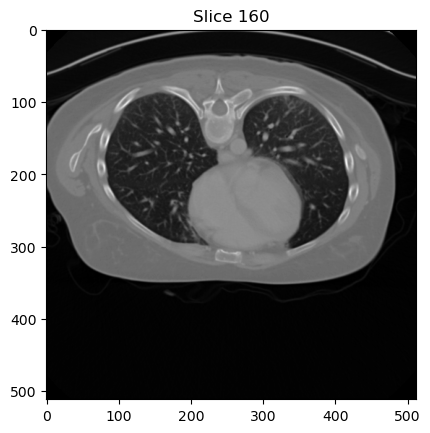

In [38]:
visualize_scan(
    image=np.flipud(np.transpose(ct_visual, (1, 0, 2))),
    interval=5, 
    pause_time=0.1,
    show_slices=None, 
    slice_dim="last"
)

#### Example of all the segmented classes

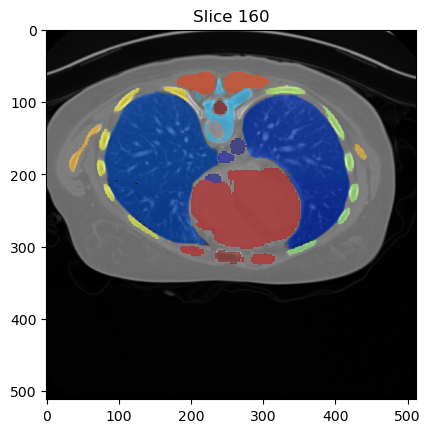

In [ ]:
from utils.plot_utils import visualize_scan

visualize_scan(
    image=np.flipud(np.transpose(ct_visual, (1, 0, 2))),
    mask=np.flipud(np.transpose(seg_all_visual, (1, 0, 2))), 
    interval=5, 
    pause_time=0.1,
    show_slices=None, 
    slice_dim="last"
)

#### Segmentation example of only the classes which we are interested on ("aorta" "right iliac artery" "left iliac artery")

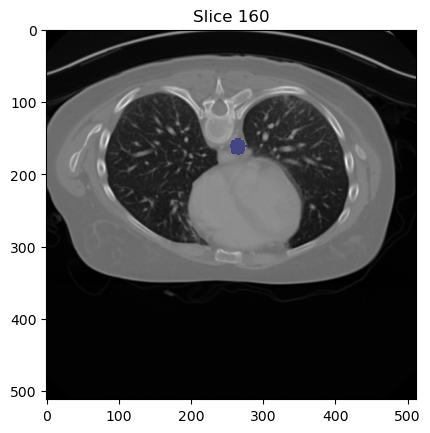

In [ ]:
from utils.plot_utils import visualize_scan

visualize_scan(
    image=np.flipud(np.transpose(ct_visual,(1,0,2))), 
    mask=np.flipud(np.transpose(seg_proc_visual,(1,0,2))), 
    interval=5, 
    pause_time=0.1, 
    show_slices=None, 
    slice_dim="last")

## 🚀 Next: Steps 5-8: Vessel analysis and reconstruction app.

In this notebook we prepared the data, and made it ready for ingestion within the `vessel geometry analysis and reconstruction` app.

**Please refer to the [README.md](README.md) for more details.**


### Step-by-Step Instructions

At this point all necessary data is available in `outputs` folder

#### 1. Required Files

Clone the app from the github repository [Vessel geometry analysis and 3D reconstruction repository](https://github.com/ai-solution-eng/hosted-trials/tree/kaiser/kaiser)

The app expects files to be organized as follows

> requirements.py
> app.py

> analysis_pipeline.py

> outputs
>> nifti_data 
>>> testing
>>>> FLARETs_0050_0000.nii.gz (The Nifti file with the scan, used to extract acquisition paramenters.)

>> pointclouds
>>> testing
>>>> FLARETs_0050_0000.npz (The npz file with 3D point cloud with real-world coordinates and colors.)

>> processed_segmentations
>>> testing
>>>> FLARETs_0050_0000.npz  (The npz file with 3D NumPy array of the final vessel segmentation.)

> .... etc..

and so forth for every patients in the dataset.


**Action:**
- Ensure the folder is structured as expected.

#### 2. Set Up a Python Virtual Environment

Using a virtual environment is crucial to avoid conflicts with other projects. We recommend using Python 3.12.

**Action:**
Open your terminal (Command Prompt or PowerShell on Windows, Terminal on macOS/Linux), navigate to your new folder, and run the following commands:

```bash
# Navigate to your project folder
cd path/to/your/Vessel_Analysis

# Create a virtual environment named 'env'
# On Windows:
python -m venv env

# On macOS / Linux:
python3.12 -m venv env

# Activate the virtual environment
# On Windows:
.\env\Scripts\activate

# On macOS / Linux:
source env/bin/activate
```
Your terminal prompt should now be prefixed with `(env)`, indicating the environment is active.

#### 3. Install Dependencies

Install the required Python libraries using the `requirements.txt` file.

**Action:**
With your virtual environment active, run the following command:
```bash
pip install -r requirements.txt
```

#### 3-b On windows 

May be necessary to install [Microsoft Visual C++ Redistributable](https://learn.microsoft.com/en-us/cpp/windows/latest-supported-vc-redist?view=msvc-170)

#### 4. Run the Analysis Script

**Action:**

```bash
streamlite run app.py
```